In [1]:
import os 
import sys 
sys.path.append("../training")
import pickle
import copy
import time
from tqdm import tqdm
import json

import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, auc, roc_curve

# QuTiP imports
from qutip import *
from math import pi, fmod
from scipy import optimize
from scipy import interpolate
from scipy import integrate
from scipy.stats import norm
import matplotlib as mpl
from matplotlib import cm
import matplotlib.colors as colors

# Local imports
from radius_labeler import RadiusLabeler # Prefer the other one, but just to have more than one labeling schema
from threshold import ThresholdModel
from sim_data import dispersive_model_MC

# Simulate data

## Physical parameters

In [2]:
NP_SEED = 0
np.random.seed(NP_SEED)

START_WINDOW = 0
END_WINDOW = 770
VAL_SPLIT = 0.3

Amp_Slice = 50
Amp_list = 10**np.linspace(-4,-1,Amp_Slice) * 2* pi
index_Amp = 32
Amp = Amp_list[index_Amp]

monte_carlo_config = {"n_shots": int(1e4/2),
                      "dt": 3.25, # ns
                      "T_slice": END_WINDOW,
                      "Amp": Amp,
                      "Omega_C": 6.20 * 2 *pi, # Resonator Freqency
                      "Omega_1": 5.50 * 2 * pi, # Qubit Frequency
                      "eta": 1, # Quantum Efficiency
                      "J_C1": 60 * 2 * pi/1000, # JC Coupling Strength two Qubits
                      "Alpha_1": -247 * 2 * pi/1000, # Anharmonicity of SC Qubits
                      "Gamma_1": 0.05 /1000, # Gamma_1, Decoherence Rate (20.0 us)
                      "Gamma_phi": 0.5 /1000, # Gamma_phi, Dephasing Rate (2.0 us)
                      "Q_C": 40, # Cavity/Resonator Hilbert space truncation
                      "Q_1": 4, # Qubit Hilbert space truncation
                      # Chi = 0.4 * 2 * pi/1000, # Dispersive Shift
}

# monte_carlo_config.update({"Delta": abs(monte_carlo_config['Omega_C'] - monte_carlo_config['Omega_1']), # Detuning
#                "Kappa": 2*monte_carlo_config['Omega_C']/7500 # Resonator Decay Rate ~ 1.65 MHz

# })


## Monte Carlo simulation

In [3]:
sim_data_dir = os.path.join("../data/simulated_data", f"0_{monte_carlo_config['T_slice']}_n{monte_carlo_config['n_shots']}")

try:
    I0_all = np.load(os.path.join(sim_data_dir, "I0_all.npy"))
    Q0_all = np.load(os.path.join(sim_data_dir, "Q0_all.npy"))
    I1_all = np.load(os.path.join(sim_data_dir, "I1_all.npy"))
    Q1_all = np.load(os.path.join(sim_data_dir, "Q1_all.npy"))
    with open(os.path.join(sim_data_dir, "mc_config.json"), "r") as f:
        monte_carlo_config = json.load(f)
    
except FileNotFoundError:

    dur_per_1000 = 85
    n_1000 = monte_carlo_config['n_shots']/(1e3)
    exp_dur = dur_per_1000*n_1000
    print(f"Expected duration: {exp_dur//60} minutes, {exp_dur%60} seconds")
    
    out = dispersive_model_MC(monte_carlo_config)
    os.makedirs(sim_data_dir, exist_ok=True)

    I0_all = out["I0_all"]
    np.save(os.path.join(sim_data_dir, "I0_all.npy"), I0_all)
    
    Q0_all = out["Q0_all"]
    np.save(os.path.join(sim_data_dir, "Q0_all.npy"), Q0_all)
    
    I1_all = out["I1_all"]
    np.save(os.path.join(sim_data_dir, "I1_all.npy"), I1_all)
    
    Q1_all = out["Q1_all"]
    np.save(os.path.join(sim_data_dir, "Q1_all.npy"), Q1_all)

    with open(os.path.join(sim_data_dir, "mc_config.json"), "w") as f:
        json.dump(monte_carlo_config, f)
    

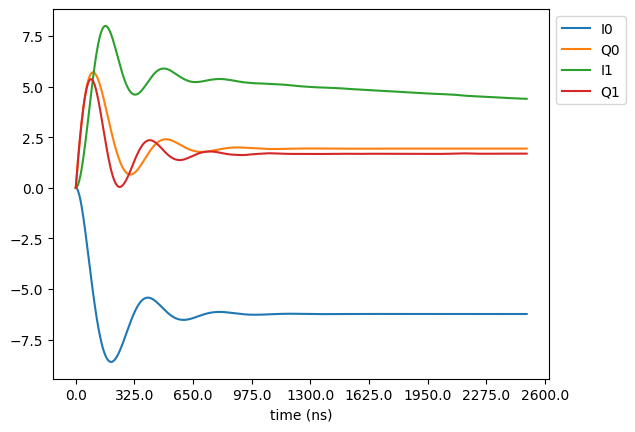

In [4]:
I0_mean = np.mean(np.array(I0_all), axis=0)
Q0_mean = np.mean(np.array(Q0_all), axis=0)
I1_mean = np.mean(np.array(I1_all), axis=0)
Q1_mean = np.mean(np.array(Q1_all), axis=0)

plt.figure()
plt.plot(I0_mean, label="I0")
plt.plot(Q0_mean, label="Q0")
plt.plot(I1_mean, label="I1")
plt.plot(Q1_mean, label="Q1")
plt.xticks(ticks = [i for i in range(801) if i%100==0], labels = [f"{i*3.25:.1f}" for i in range(801) if i%100==0])
plt.xlabel("time (ns)")
plt.legend(bbox_to_anchor=[1,1])
plt.show()
plt.close()

In [5]:
X_0 = np.zeros((I0_all.shape[0], 2*I0_all.shape[1]), dtype=I0_all.dtype)
X_0[:, [i for i in range(X_0.shape[1]) if i%2==0]] = I0_all
X_0[:, [i for i in range(X_0.shape[1]) if i%2==1]] = Q0_all
y_0 = np.zeros((X_0.shape[0],))

X_1 = np.zeros((I1_all.shape[0], 2*I1_all.shape[1]), dtype=I1_all.dtype)
X_1[:, [i for i in range(X_1.shape[1]) if i%2==0]] = I1_all
X_1[:, [i for i in range(X_0.shape[1]) if i%2==1]] = Q1_all
y_1 = np.ones((X_1.shape[0],))


#################################################

X = copy.deepcopy(np.concatenate((X_0, X_1), axis=0))
y = copy.deepcopy(np.concatenate((y_0, y_1), axis=0))

## Label transition errors

In [6]:
idx_0 = np.where(((y==0)&(X[:,-2]<-5)))[0]
idx_1 = np.where(((y==1)&(X[:,-2]>4.9)))[0]
idx_excite = np.where(((y==0)&(X[:,-2]>4.9)))[0]  # excitation
idx_relax = np.where(((y==1)&(X[:,-2]<-5)))[0]  # relaxation
idx_other = np.array([i for i in range(y.shape[0]) if i not in np.concatenate((idx_0,idx_1,idx_excite,idx_relax), axis=0)])

print(f"idx_0.shape: {idx_0.shape}")
print(f"idx_1.shape: {idx_1.shape}")
print(f"idx_excite.shape: {idx_excite.shape}")
print(f"idx_relax.shape: {idx_relax.shape}")
print(f"idx_other.shape: {idx_other.shape}")

idx_0.shape: (5000,)
idx_1.shape: (4420,)
idx_excite.shape: (0,)
idx_relax.shape: (542,)
idx_other.shape: (38,)


/tmp/ipykernel_69405/2728991962.py:15: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


Text(0.5, 1.0, 'Transition-labeling method: Discriminating line')

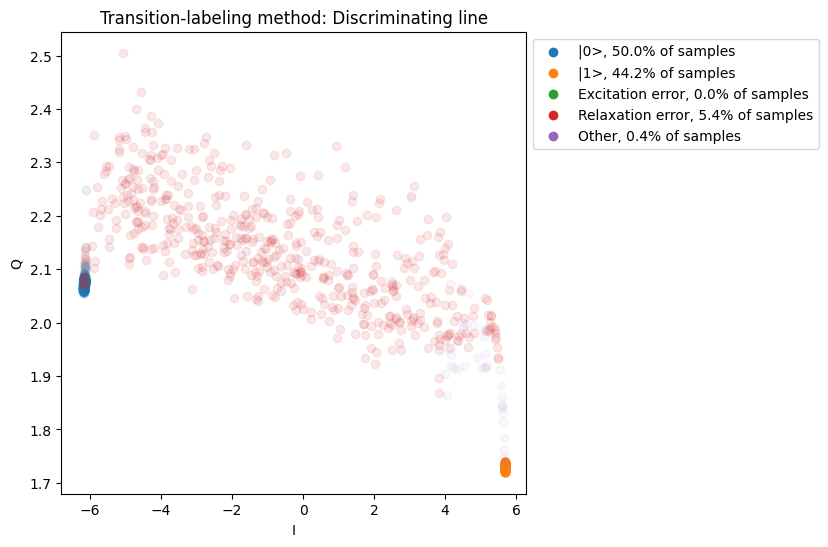

In [7]:

thresholder = ThresholdModel()
X_I_tmean, X_Q_tmean = thresholder.split_and_time_average(X)
fig, ax1 = plt.subplots(1, 1, figsize=(6,6))


ax1.scatter(X_I_tmean[idx_0], X_Q_tmean[idx_0], label = f"|0>, {(100*len(idx_0)/X.shape[0]):.1f}% of samples", alpha=0.1)
ax1.scatter(X_I_tmean[idx_1], X_Q_tmean[idx_1], label = f"|1>, {(100*len(idx_1)/X.shape[0]):.1f}% of samples", alpha=0.1)
ax1.scatter(X_I_tmean[idx_excite], X_Q_tmean[idx_excite], label = f"Excitation error, {(100*len(idx_excite)/X.shape[0]):.1f}% of samples", alpha=0.1)
ax1.scatter(X_I_tmean[idx_relax], X_Q_tmean[idx_relax], label = f"Relaxation error, {(100*len(idx_relax)/X.shape[0]):.1f}% of samples", alpha=0.1)
ax1.scatter(X_I_tmean[idx_other], X_Q_tmean[idx_other], label = f"Other, {(100*len(idx_other)/X.shape[0]):.1f}% of samples", alpha=0.05)
ax1.set_xlabel("I")
ax1.set_ylabel("Q")

leg = ax1.legend(bbox_to_anchor = [1,1])
for lh in leg.legendHandles:
    lh.set_alpha(1)

ax1.set_title("Transition-labeling method: Discriminating line")

## Fourier transform 

First, convert to complex numbers, then amplitude and phase

In [8]:
# Convert to complex
X_I = X[:, [i for i in range(X.shape[1]) if i%2==0]]
X_Q = X[:, [i for i in range(X.shape[1]) if i%2==1]]
X_complex = X_I + 1j*X_Q

# Fourier transform
X_fft = np.fft.fft(X_complex, axis=1)

# Order by increasing frequency 
X_fft_freqs = np.fft.fftfreq(X_complex.shape[1])/(3.25e-9)
freq_ordering = np.argsort(X_fft_freqs)
X_fft_freqs = X_fft_freqs[freq_ordering]
X_fft = X_fft[:, freq_ordering]

## Amplitude/phase vs. frequency, class differences

In [9]:
labels = [0, 1, 2, 3, 4]

y_prime = np.zeros(y.shape)
y_prime[idx_1] = 1
y_prime[idx_excite] = 2
y_prime[idx_relax] = 3
y_prime[idx_other] = 4

label_legends = {0: f"|0> = {(100*len(idx_0)/X.shape[0]):.1f}% of samples", 
                 1: f"|1> = {(100*len(idx_1)/X.shape[0]):.1f}% of samples", 
                2: f"Excitation-error = {(100*len(idx_excite)/X.shape[0]):.1f}% of samples",
                3: f"Relaxation-error= {(100*len(idx_relax)/X.shape[0]):.1f}% of samples",
                4: f"Other: {(100*len(idx_other)/X.shape[0]):.1f}% of samples"
                }

/data/aelabd/miniforge3/envs/ml4qick-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/aelabd/miniforge3/envs/ml4qick-env/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


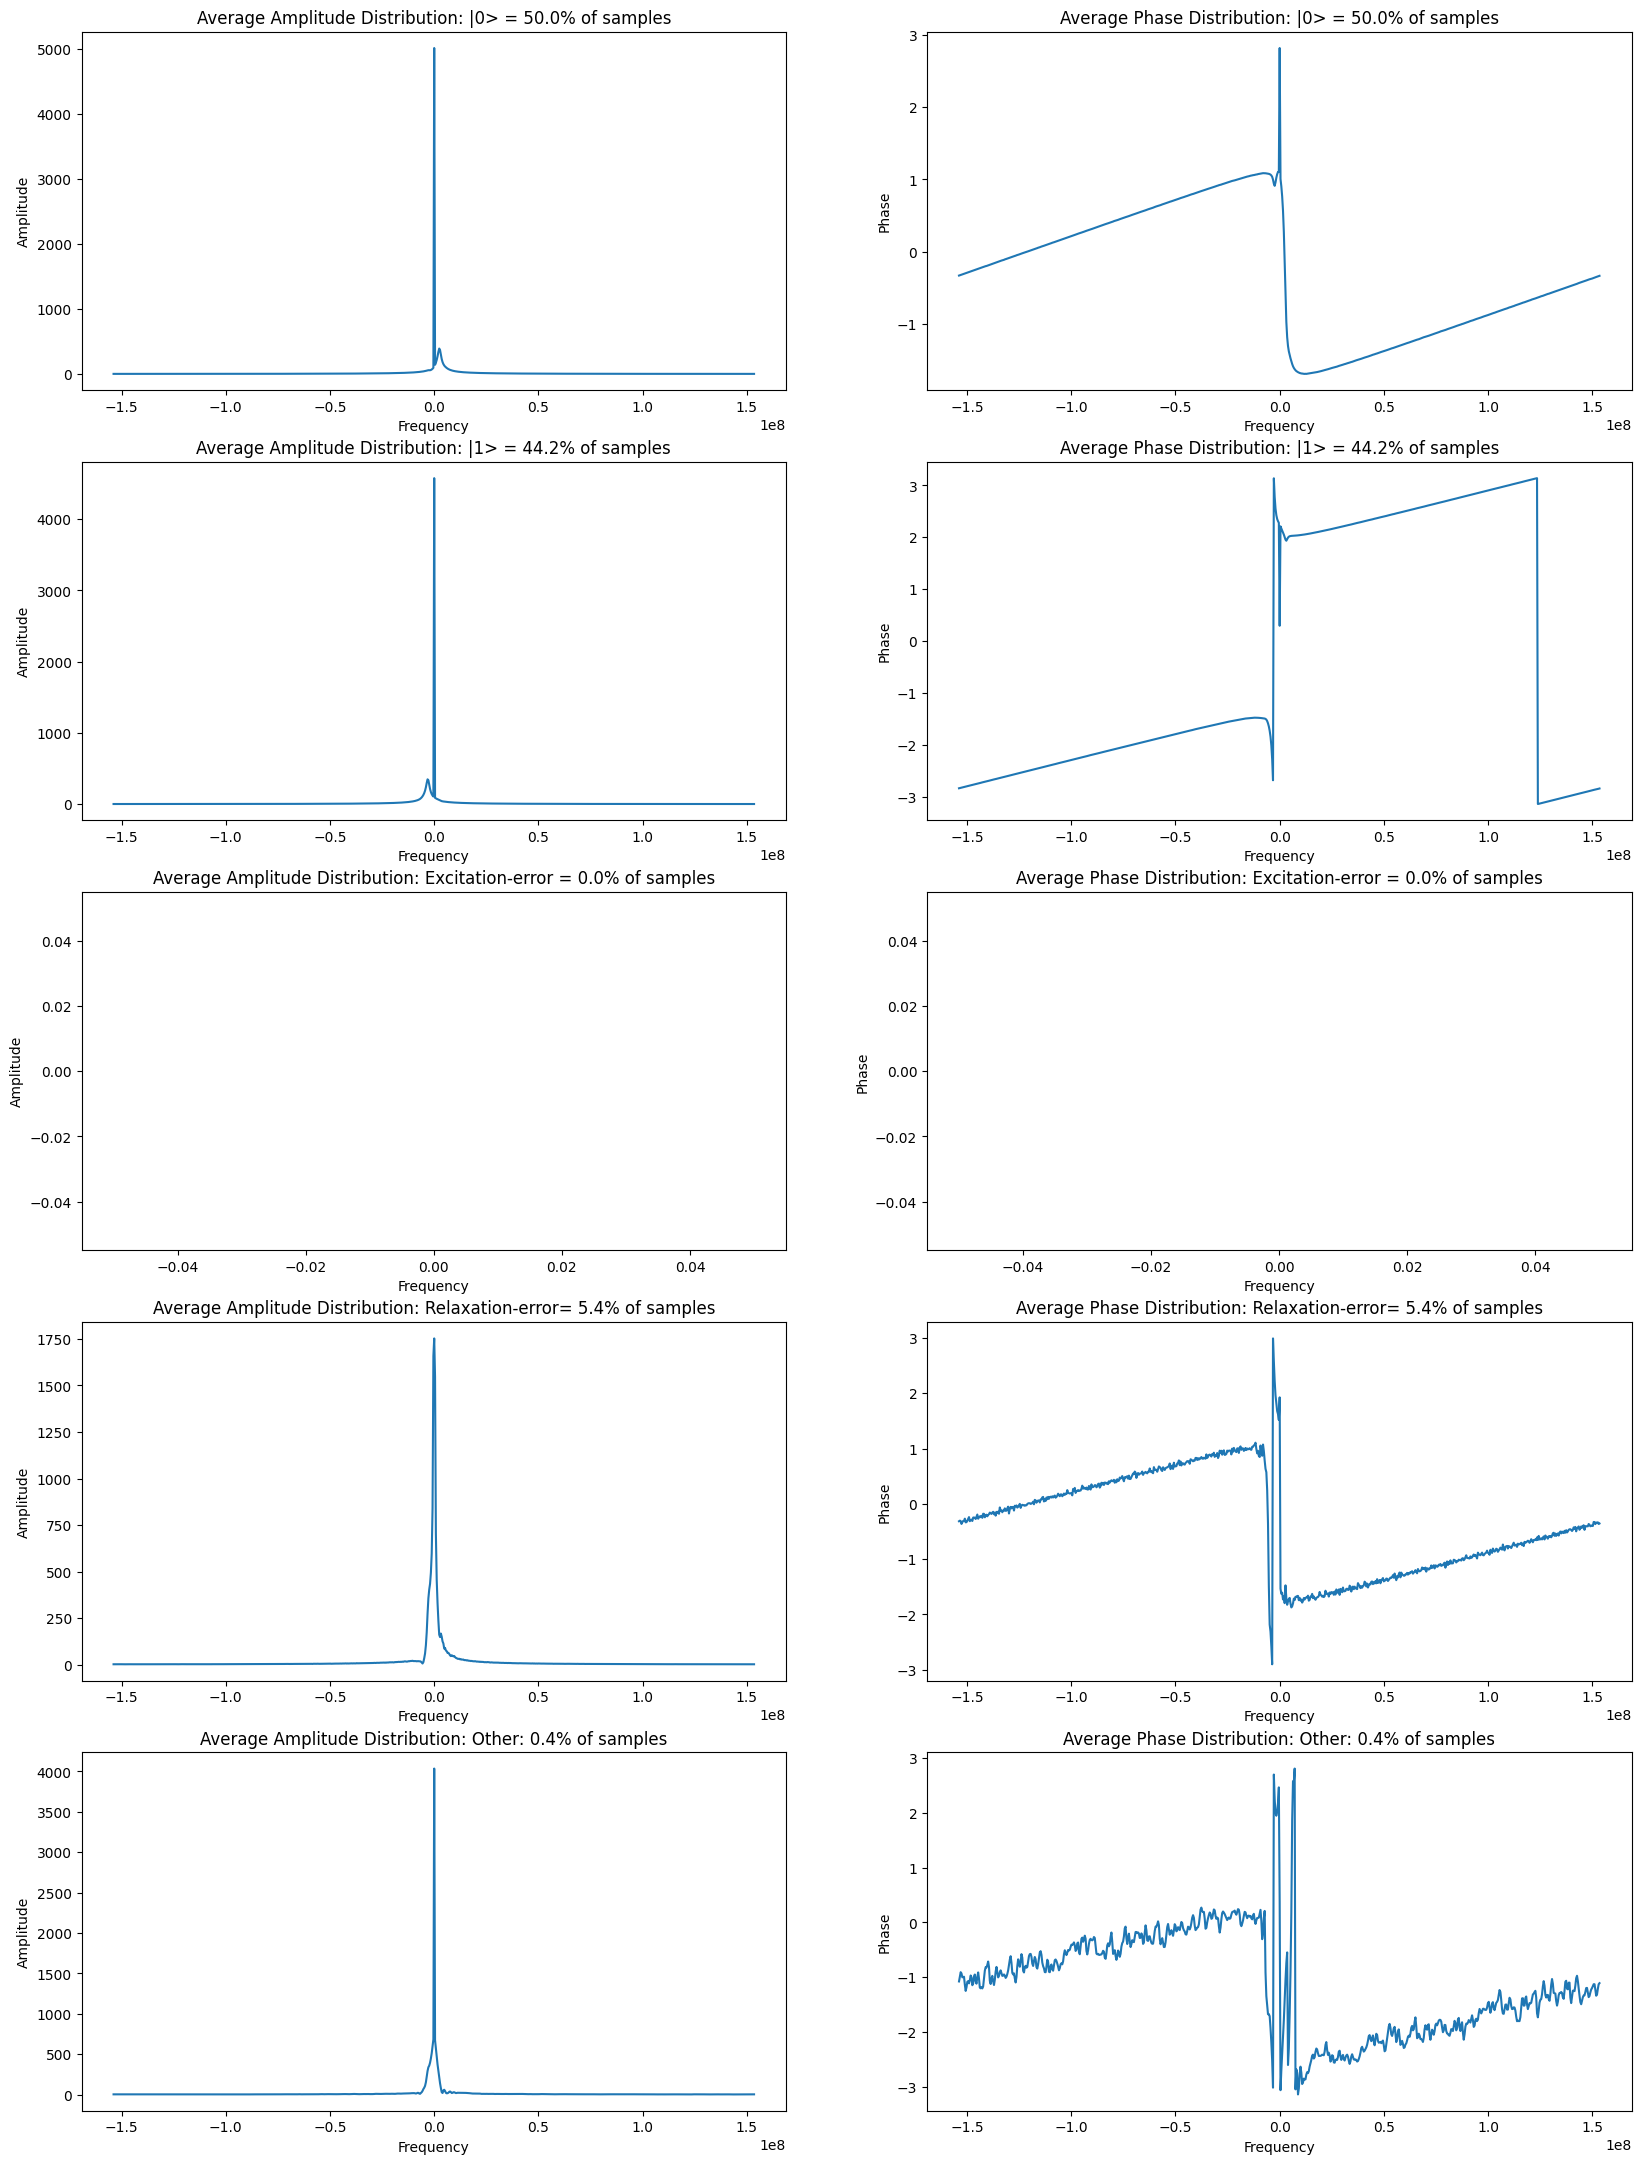

In [10]:
fig, axes = plt.subplots(5, 2, figsize = (20, 27))

for label in labels:
    label_idx = np.where(y_prime==label)[0]
    label_legend = label_legends[label]
    X_fft_label_mean = np.mean(X_fft[label_idx], axis=0)
    
    X_amp_label_mean = np.abs(X_fft_label_mean)
    axes[label, 0].plot(X_fft_freqs, X_amp_label_mean, label = label_legend)
    axes[label, 0].set_xlabel("Frequency")
    axes[label, 0].set_ylabel("Amplitude")
    axes[label, 0].set_title(f"Average Amplitude Distribution: {label_legends[label]}")

    X_phase_label_mean = np.angle(X_fft_label_mean)
    axes[label, 1].plot(X_fft_freqs, X_phase_label_mean, label = label_legend)
    axes[label, 1].set_xlabel("Frequency")
    axes[label, 1].set_ylabel("Phase")
    axes[label, 1].set_title(f"Average Phase Distribution: {label_legends[label]}")
    

## Same thing, but zoomed in near 1MHz

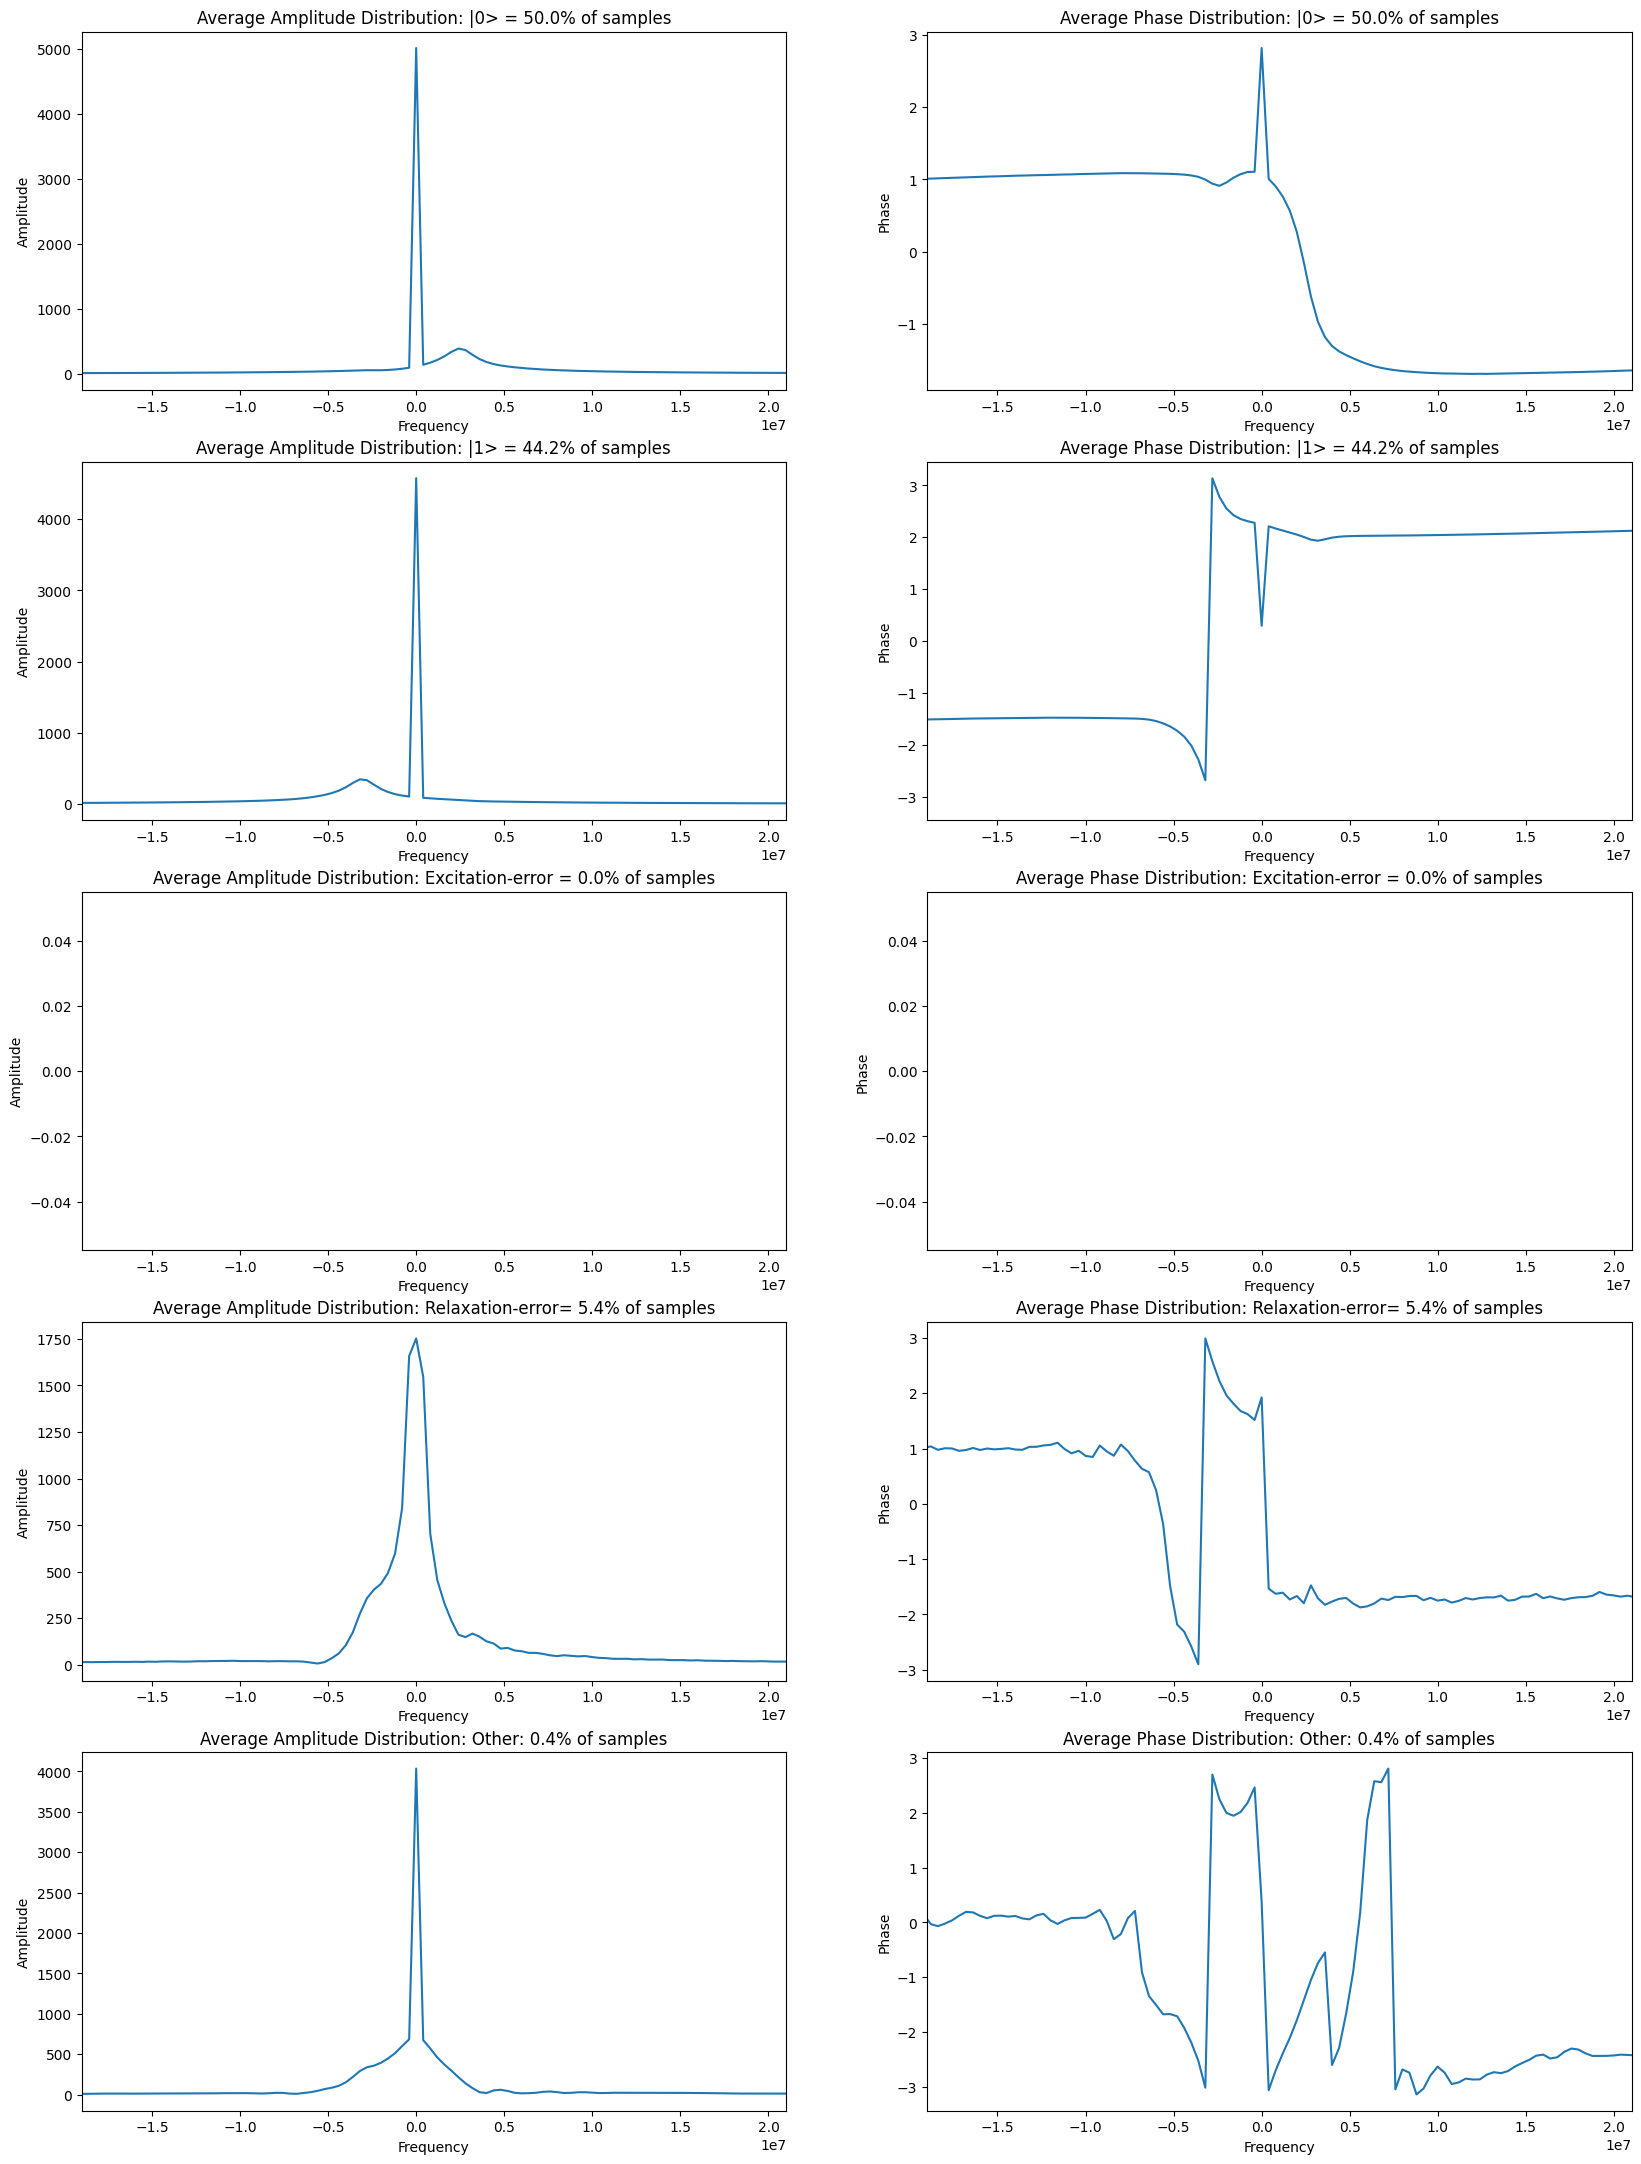

In [16]:
center = 1e6
ran = 2e7
xlims = (center - ran, center + ran)
fig, axes = plt.subplots(5, 2, figsize = (20, 27))

for label in labels:
    label_idx = np.where(y_prime==label)[0]
    label_legend = label_legends[label]
    X_fft_label_mean = np.mean(X_fft[label_idx], axis=0)
    
    X_amp_label_mean = np.abs(X_fft_label_mean)
    axes[label, 0].plot(X_fft_freqs, X_amp_label_mean, label = label_legend)
    axes[label, 0].set_xlim(xlims)
    axes[label, 0].set_xlabel("Frequency")
    axes[label, 0].set_ylabel("Amplitude")
    axes[label, 0].set_title(f"Average Amplitude Distribution: {label_legends[label]}")

    X_phase_label_mean = np.angle(X_fft_label_mean)
    axes[label, 1].plot(X_fft_freqs, X_phase_label_mean, label = label_legend)
    axes[label, 1].set_xlim(xlims)
    axes[label, 1].set_xlabel("Frequency")
    axes[label, 1].set_ylabel("Phase")
    axes[label, 1].set_title(f"Average Phase Distribution: {label_legends[label]}")
    

Text(0.5, 0.98, 'Simulated data (dispersive hamiltonian Monte-Carlo), n_samples = 10000')

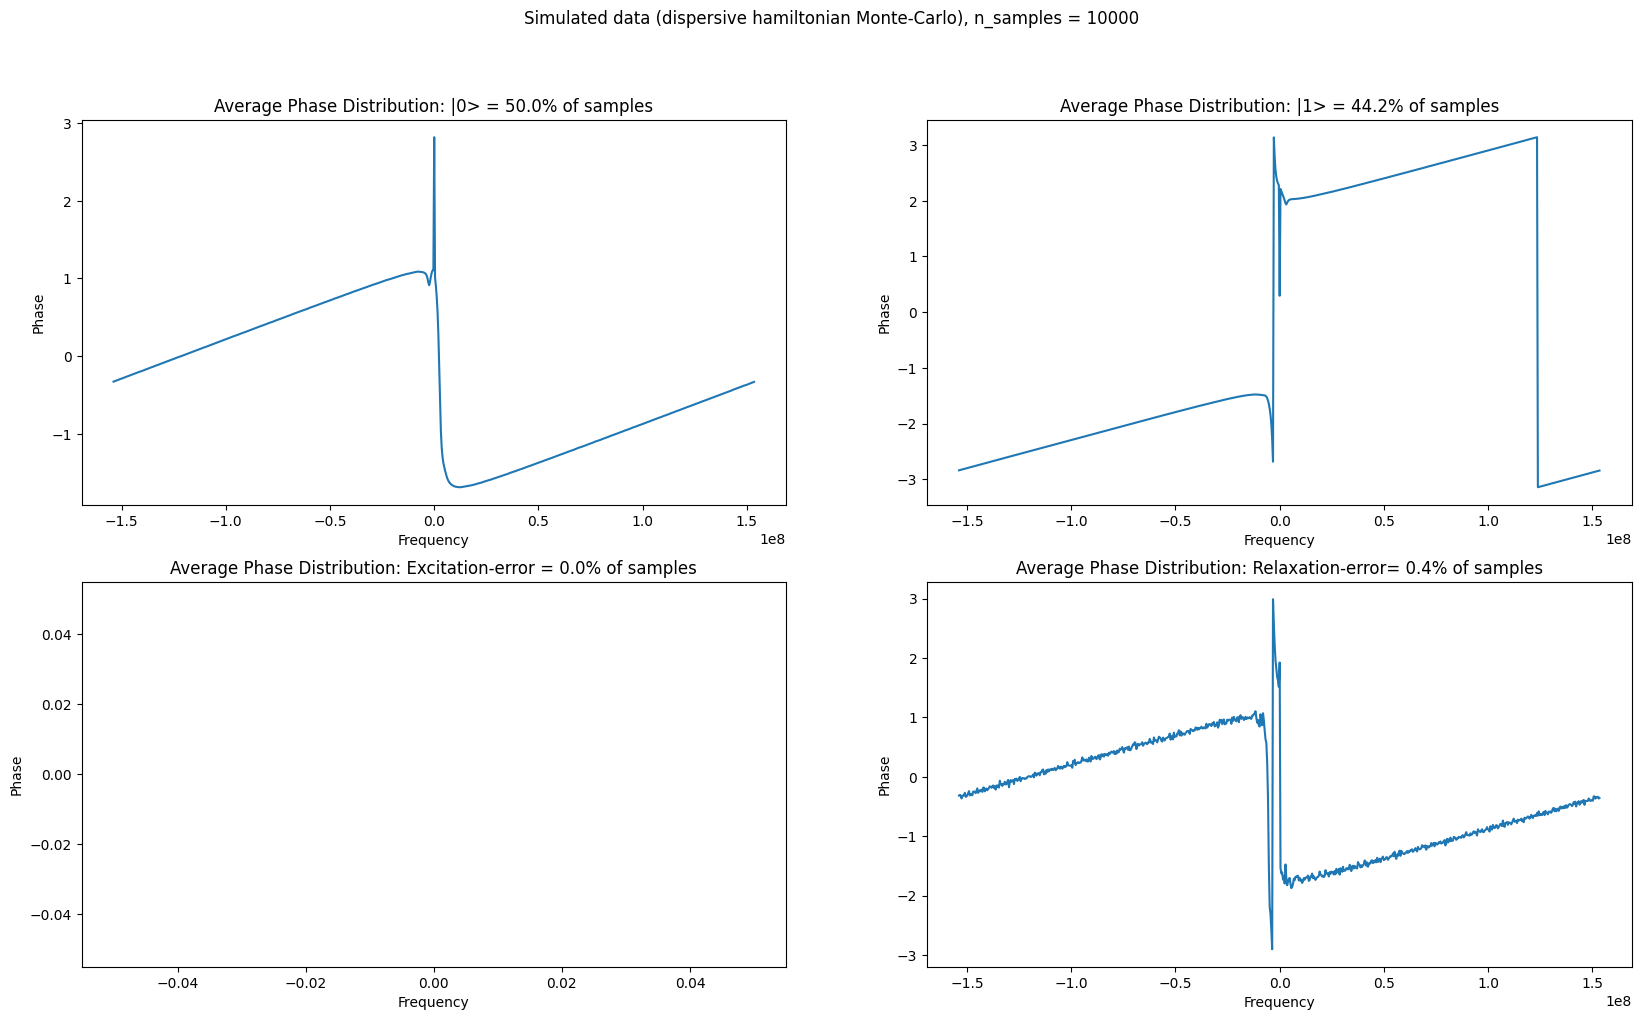

In [15]:
labels = [0, 1, 2, 3, 4]

y_prime = np.zeros(y.shape)
y_prime[idx_1] = 1
y_prime[idx_excite] = 2
y_prime[idx_relax] = 3
y_prime[idx_other] = 4

label_legends = {0: f"|0> = {(100*len(idx_0)/X.shape[0]):.1f}% of samples", 
                 1: f"|1> = {(100*len(idx_1)/X.shape[0]):.1f}% of samples", 
                2: f"Excitation-error = {(100*len(idx_other)/X.shape[0]):.1f}% of samples",
                3: f"Relaxation-error= {(100*len(idx_relax)/X.shape[0]):.1f}% of samples",
                }

labels = [0, 1, 2, 3]
label_locs = [(0,0), (0,1), (1,0), (1,1)]

fig, axes = plt.subplots(2, 2, figsize = (20, 11))
for label in labels:

    label_idx = np.where(y_prime==label)[0]
    
    label_legend = label_legends[label]
    X_fft_label_mean = np.mean(X_fft[label_idx], axis=0)

    X_phase_label_mean = np.angle(X_fft_label_mean)
    axes[label_locs[label]].plot(X_fft_freqs, X_phase_label_mean, label = label_legend)
    axes[label_locs[label]].set_xlabel("Frequency")
    axes[label_locs[label]].set_ylabel("Phase")
    axes[label_locs[label]].set_title(f"Average Phase Distribution: {label_legends[label]}")

fig.suptitle(f"Simulated data (dispersive hamiltonian Monte-Carlo), n_samples = {X_fft.shape[0]}")

## Find exact transition frequency

In [17]:
def find_transition_idx(X, diff_window_size = 1, smooth_window_size = 1): 
    # X.shape = (SAMPLE_LENGTH,)
    # Assumes SAMPLE_LENGTH >> window_size
    
    X_window_diff = np.zeros(X.shape)
    for i in range(diff_window_size, X.shape[0]):
        window_diff_i = np.abs(X[i] - X[i - diff_window_size])
        X_window_diff[i] = window_diff_i
        
    X_window_diff = X_window_diff[diff_window_size:]

    # Smooth
    X_window_diff_smoothed = np.zeros(X_window_diff.shape)
    for i in range(smooth_window_size, X_window_diff.shape[0]):
        window_mean_i = np.mean(X_window_diff[i-smooth_window_size:i])
        X_window_diff_smoothed[i] = window_mean_i
        
    X_window_diff_smoothed = X_window_diff_smoothed[smooth_window_size:]

    # Find (approximate) max index
    max_diff_idx = np.where(X_window_diff_smoothed == max(X_window_diff_smoothed))[0]
    return max_diff_idx+diff_window_size+smooth_window_size

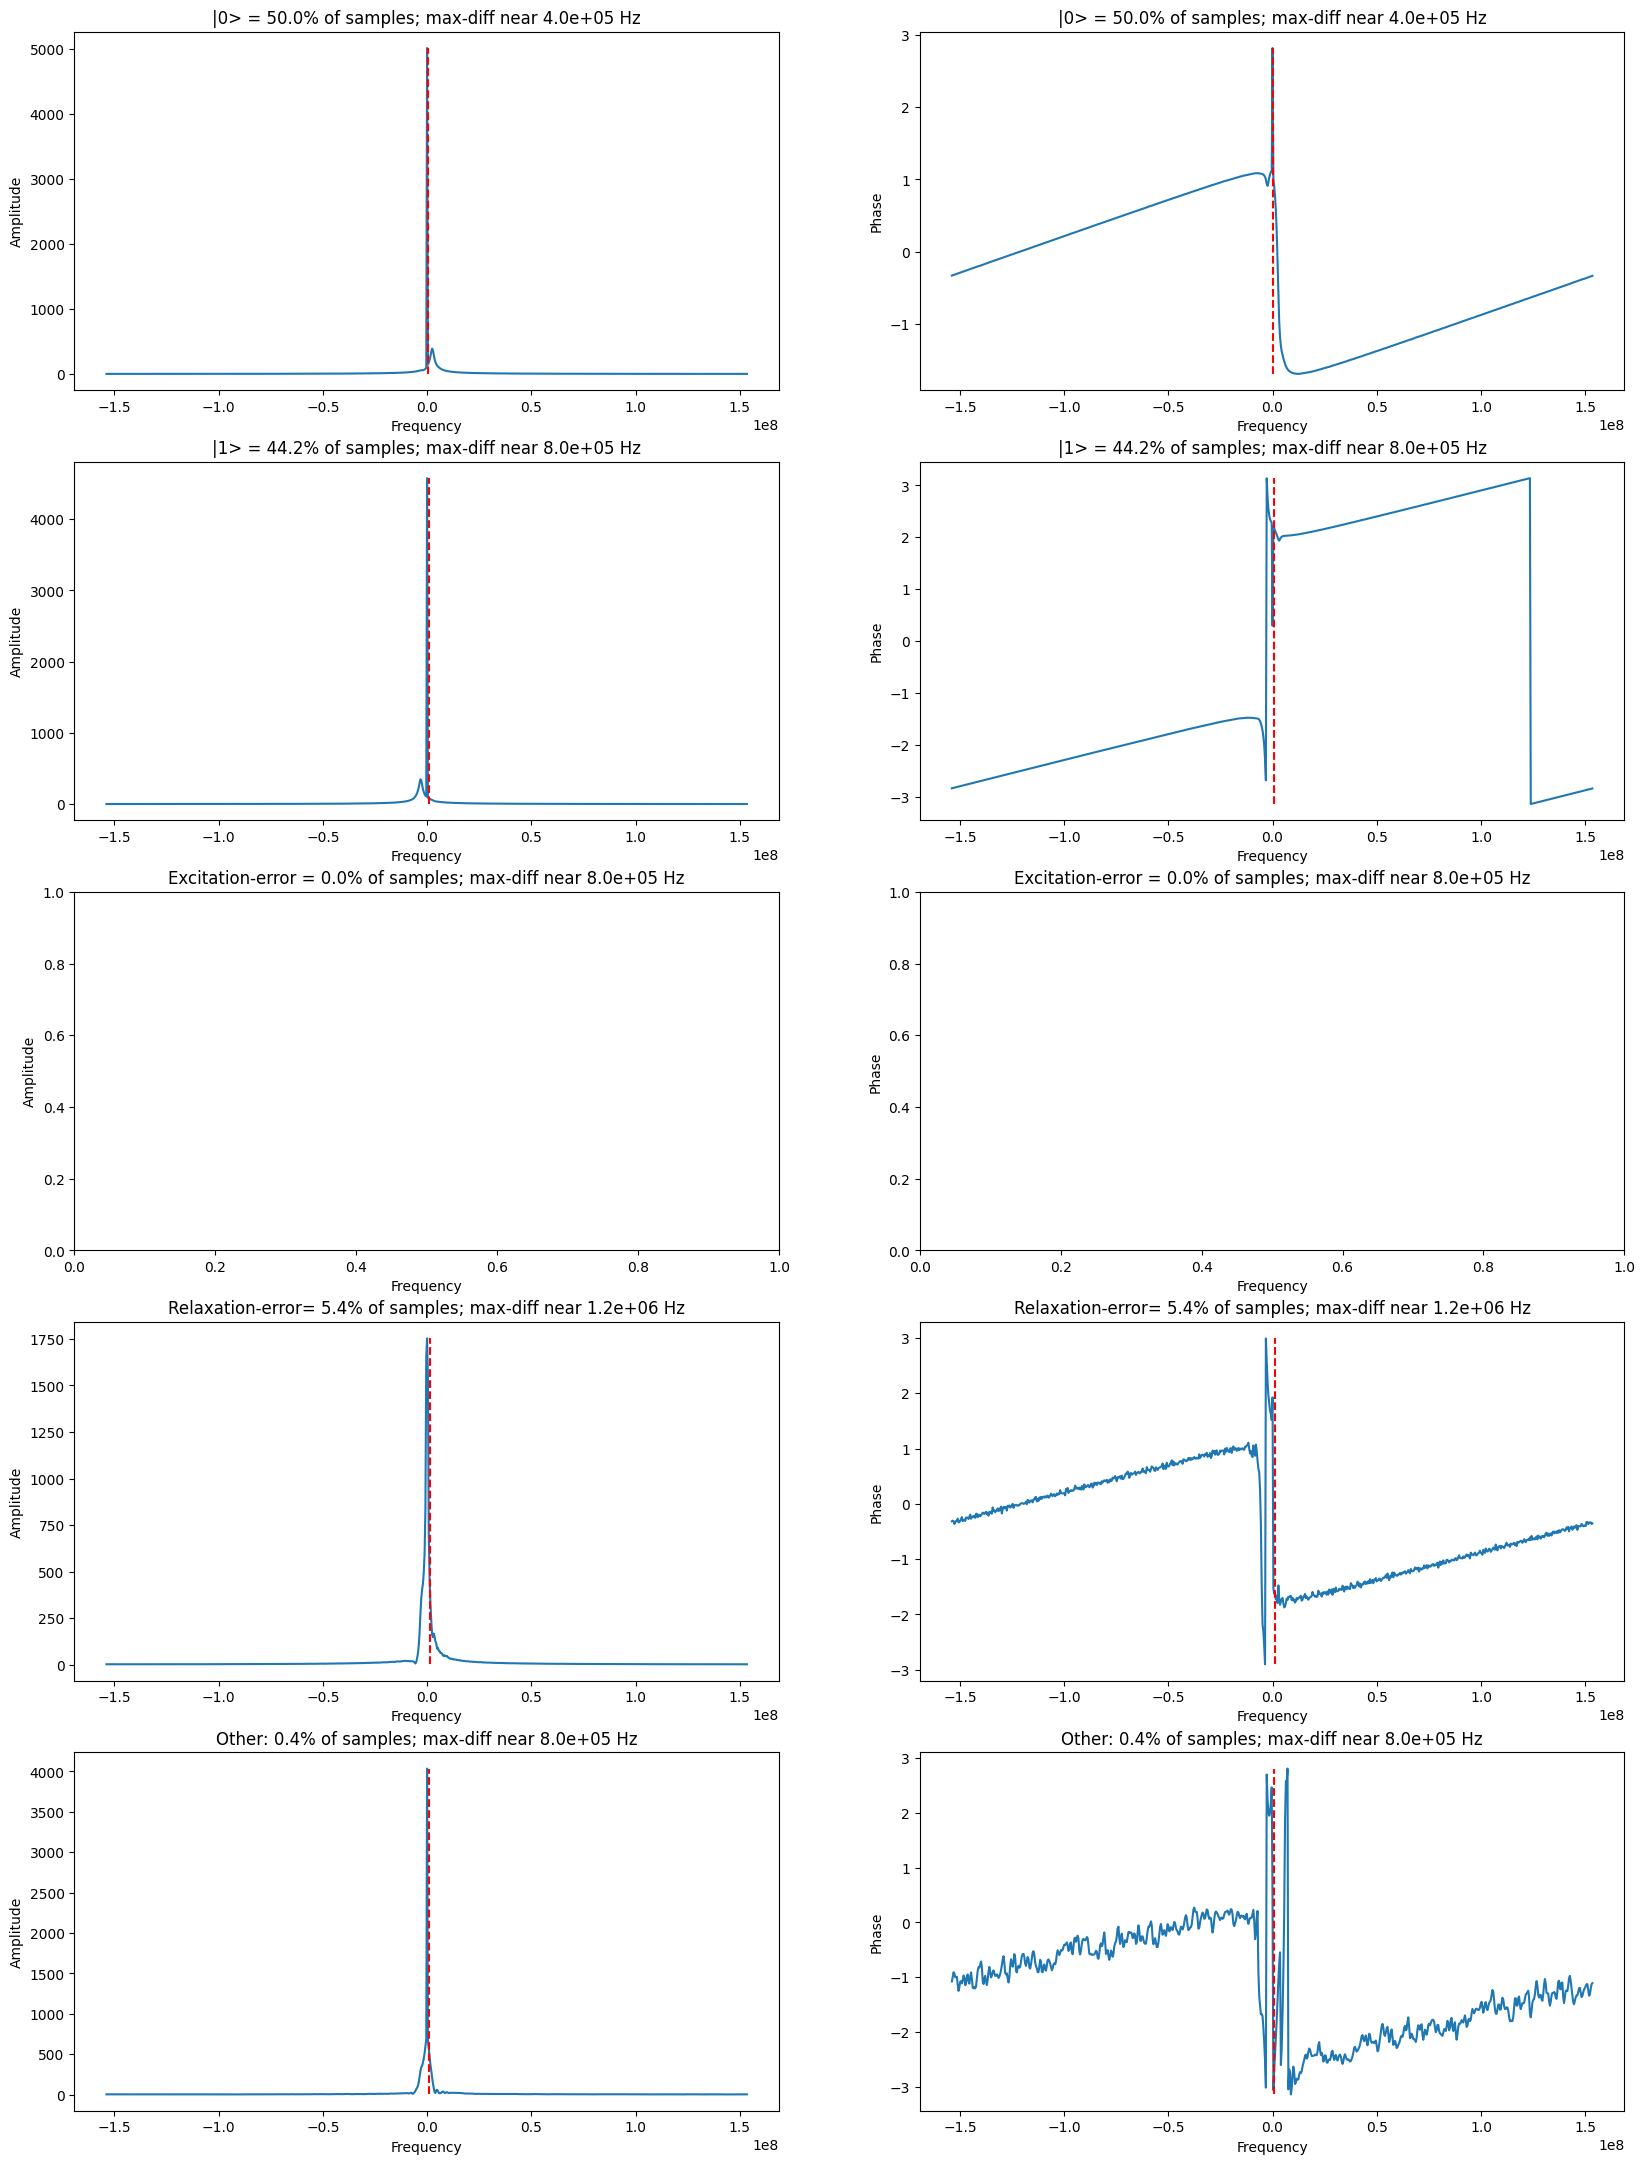

In [20]:
fig, axes = plt.subplots(5, 2, figsize = (20, 27))

for label in labels:
    label_idx = np.where(y_prime==label)[0]
    label_legend = label_legends[label]

    if len(label_idx) >= 1:
        X_fft_label_mean = np.mean(X_fft[label_idx], axis=0)
        
        X_amp_label_mean = np.abs(X_fft_label_mean)
        X_amp_label_mean_max_diff_idx = find_transition_idx(X_amp_label_mean)
        X_amp_label_mean_max_diff_freq = X_fft_freqs[X_amp_label_mean_max_diff_idx]
        axes[label, 0].plot(X_fft_freqs, X_amp_label_mean, label = label_legend)
        axes[label, 0].plot(X_amp_label_mean_max_diff_freq[0]*np.ones(1000), np.linspace(min(X_amp_label_mean), max(X_amp_label_mean), 1000), 'r--')

        X_phase_label_mean = np.angle(X_fft_label_mean)
        X_phase_label_mean_max_diff_idx = find_transition_idx(X_phase_label_mean)
        X_phase_label_mean_max_diff_freq = X_fft_freqs[X_phase_label_mean_max_diff_idx]
        axes[label, 1].plot(X_fft_freqs, X_phase_label_mean, label = label_legend)
        axes[label, 1].plot(X_amp_label_mean_max_diff_freq[0]*np.ones(1000), np.linspace(min(X_phase_label_mean), max(X_phase_label_mean), 1000), 'r--')
    
    axes[label, 0].set_xlabel("Frequency")
    axes[label, 0].set_ylabel("Amplitude")
    axes[label, 0].set_title(f"{label_legends[label]}; max-diff near {X_amp_label_mean_max_diff_freq[0]:.1e} Hz")
    
    axes[label, 1].set_xlabel("Frequency")
    axes[label, 1].set_ylabel("Phase")
    axes[label, 1].set_title(f"{label_legends[label]}; max-diff near {X_amp_label_mean_max_diff_freq[0]:.1e} Hz")
    
